Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step - loss: 0.8964 - mean_squared_error: 0.9523 - val_loss: 0.8343 - val_mean_squared_error: 0.9208
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - loss: 0.9103 - mean_squared_error: 1.0024 - val_loss: 0.9448 - val_mean_squared_error: 1.0621
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - loss: 0.7498 - mean_squared_error: 0.8715 - val_loss: 0.8103 - val_mean_squared_error: 0.9544
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step - loss: 0.8977 - mean_squared_error: 1.0453 - val_loss: 0.6627 - val_mean_squared_error: 0.8271
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - loss: 0.7961 - mean_squared_error: 0.9651 - val_loss: 0.8014 - val_mean_squared_error: 0.9842
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - loss: 0.7372 - mean_squared_error: 0.9223 - val_loss: 0.7640 - val_mean_squared_error: 0.9605
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step - loss: 0.6898 - mean_squared_error: 0.8887 - val_loss: 0.6409 - va

Model: "autoencoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_9 (Functional)       │ ?                      │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_11 (Functional)      │ ?                      │         5,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,480 (76.10 KB)

 Trainable params: 6,493 (25.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,987 (50.73 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


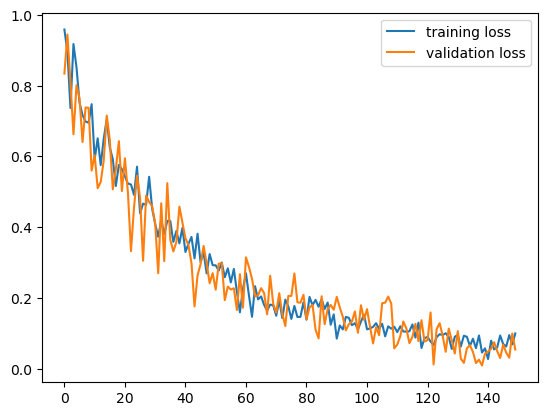

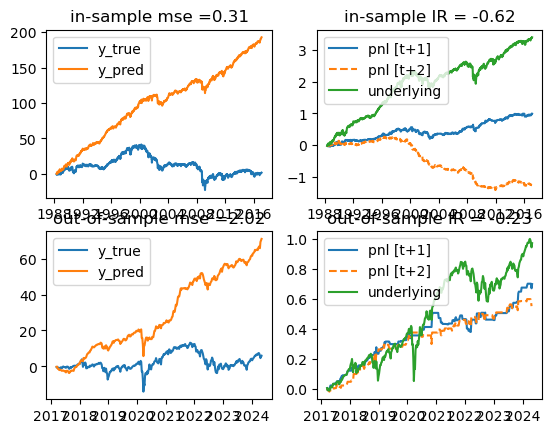

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import os

def log_normal_pdf(sample, mean, logvar):
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + tf.math.log(2. * np.pi)), axis=1)

def mse(y_pred, y_true):
    return (y_true - y_pred) ** 2

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, input_columns=None, label_columns=None, all_columns=None):
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.train_label_indices = {name: i for i, name in enumerate(all_columns)}

    # ...and the input column indices
    self.input_columns = input_columns
    if input_columns is not None:
      self.input_columns_indices = {name: i for i, name in enumerate(input_columns)}
    self.train_input_indices = {name: i for i, name in enumerate(all_columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.input_columns is not None:
        inputs = tf.stack([inputs[:, :, self.train_input_indices[name]] for name in self.input_columns], axis=-1)
      if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.train_label_indices[name]] for name in self.label_columns], axis=-1)
      return inputs, labels

  def make_dataset(self, data, shuffle = False, batchsize = 500,):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                                sequence_stride=1, sampling_rate=1, shuffle=shuffle, batch_size=batchsize)
      ds = ds.map(self.split_window)
      return ds

class Autoencoder(tf.keras.models.Model):
    def __init__(self, num_timesteps, num_inputs, num_hidden):
        super(Autoencoder, self).__init__()
        self.pool = 4
        self.strides = 4
        self.filters = 32

        enc_inp = tf.keras.Input(shape=(num_timesteps, num_inputs), name="input")
        x = tf.keras.layers.Conv1D(filters=self.filters, kernel_size=3, activation=None, use_bias=True, padding='causal')(enc_inp)
        x = tf.keras.layers.MaxPooling1D(pool_size=self.pool, strides=self.strides, padding='same')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(2 * num_hidden, activation='sigmoid')(x)
        self.encoder = tf.keras.Model(inputs=enc_inp, outputs=x)

        dec_inp = tf.keras.Input(shape=(num_hidden,))
        y = tf.keras.layers.Dense(units=int(num_timesteps/ self.strides) * self.filters, activation='relu')(dec_inp)
        y = tf.keras.layers.Reshape(target_shape=(int(num_timesteps/ self.strides), self.filters))(y)
        y = tf.keras.layers.Conv1DTranspose(filters=32, kernel_size=3, strides=self.strides, activation='relu', use_bias=True, padding='same')(y)
        y = tf.keras.layers.Conv1DTranspose(filters=24, kernel_size=3, strides=1, activation='relu', use_bias=True, padding='same')(y)
        y = tf.keras.layers.Conv1DTranspose(filters=num_inputs, kernel_size=3, strides=1, activation=None, use_bias=True, padding='same')(y)
        self.decoder = tf.keras.Model(inputs=dec_inp, outputs=y)

    def decode(self, z):
        logits = self.decoder(z)
        probs = tf.sigmoid(logits)
        return probs

    def encode(self, x):
        # tmp = self.encoder(x)
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = 0.001 * tf.random.normal(shape=mean.shape)    # 0.01 constrains effective sampled z to be closer to mean
        return eps * tf.exp(logvar) + mean

    def get_loss_fun(self):
        def loss(inp, y_pred):
            mean, logvar = self.encode(inp)
            z = self.reparameterize(mean, logvar)
            x_logit = self.decoder(z)
            # rec_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=inp)
            rec_loss = mse(x_logit, inp)
            logpx_z = - tf.reduce_mean(rec_loss)
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            return - logpx_z - 0.1 * tf.reduce_mean(logpz - logqz_x)
        return loss

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decoder(z)
        return x_logit


if __name__ == '__main__':
    # PREPARE DATA
    df = pd.read_excel(os.path.join('..', 'data', 'raw', 'market_data.xlsx'), sheet_name='US', engine='openpyxl')
    df = df.set_index(df['Date'])
    df = df.drop(columns='Date')
    df0 = df.copy()
    cols = ['M2', 'CPI', '_MKT']
    df = df[cols]
    df = df.pct_change().dropna()

    # hold out test data
    n = len(df)
    df1, df2 = df[:int(0.8*n)], df[int(0.8*n):]
    mm_scaler = preprocessing.StandardScaler()
    df1m, df2m = mm_scaler.fit_transform(df1), mm_scaler.transform(df2)
    train_df, test_df = pd.DataFrame(df1m, index=df1.index, columns=df1.columns), pd.DataFrame(df2m, index=df2.index, columns=df2.columns)

    # sliding window
    lb = 4
    window = WindowGenerator(input_width=lb, label_width=lb, shift=0, input_columns=cols, label_columns=cols, all_columns=df.columns)
    td = window.make_dataset(train_df, shuffle=True)
    is_data = td.take(2)
    os_data = td.skip(2)
    x0 = np.concatenate([y for x, y in is_data], axis=0)

    # # Set up NN
    model = Autoencoder(num_timesteps=lb, num_inputs=3, num_hidden=5)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=50, decay_rate=0.99, staircase=True)
    model.compile(loss=model.get_loss_fun(), optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), metrics=[tf.metrics.MeanSquaredError(), ])
    model.run_eagerly = True
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')
    history = model.fit(is_data, validation_data=os_data, epochs=150, callbacks=[early_stopping])
    model.summary()

    fig, axs = plt.subplots()
    axs.plot(history.history['loss'])
    axs.plot(history.history['val_loss'])
    axs.legend(['training loss', 'validation loss'])

    eval_train = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
    eval_test = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)

    # CHECK IS and OS performance and P/L of a trading strategy
    plt.figure()
    plt.subplot(221)
    y_pred = model.predict(eval_train)
    y_true = np.concatenate([y for x, y in eval_train], axis=0)
    mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
    plt.plot(train_df.index[lb-1:], np.cumsum(y_true[:, -1, -1], axis=0))
    plt.plot(train_df.index[lb-1:], np.cumsum(y_pred[:, -1, -1], axis=0), '-')
    plt.title('in-sample mse =%1.2f' %mse )
    plt.legend(['y_true', 'y_pred'])

    plt.subplot(222)
    y_mkt = df0.iloc[(lb-1):int(0.8*n),:].loc[:,'_MKT'].pct_change()
    # position taking: simple switch
    pos = ((y_pred[:,-1, 0] < 0) & (y_pred[:,-1, 1] > 0)) * 1
    pos[pos == -1] = 0   # no shorting
    pnl = pos[1:] * y_mkt[:-1]
    # check robustness to implementation delay
    pnl2 = pos[2:] * y_mkt[:-2]
    plt.plot(y_mkt.index[:-1], np.cumsum(pnl))
    plt.plot(y_mkt.index[:-2], np.cumsum(pnl2),'--')
    plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))
    # relative performance
    tmp = pnl - y_mkt[:-1]
    sr = tmp.mean()/tmp.std() * np.sqrt(52)
    plt.title('in-sample IR = %1.2f' %sr)
    plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'])

    plt.subplot(223)
    y_pred = model.predict(eval_test)
    y_true = np.concatenate([y for x, y in eval_test], axis=0)
    middle = model.encoder(y_true)
    mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
    plt.plot(test_df.index[lb-1:], np.cumsum(y_true[:,-1,-1], axis=0))
    plt.plot(test_df.index[lb-1:], np.cumsum(y_pred[:,-1,-1], axis=0), '-')
    # plt.plot(test_df.index[lb-1:], middle[:,-1,-1], '-')
    plt.title('out-of-sample mse =%1.2f' %mse )
    plt.legend(['y_true', 'y_pred', 'middle'])

    plt.subplot(224)
    y_mkt = df0.iloc[lb+int(0.8*n):,:].loc[:,'_MKT'].pct_change()
    # position taking: simple switch
    pos = ((y_pred[:,-1,0] < 0) & (y_pred[:,-1,1] > 0)) * 1
    pos[pos == -1] = 0
    pnl = pos[1:] * y_mkt[:-1]
    # check robustness to implementation delay
    pnl2 = pos[2:] * y_mkt[:-2]
    plt.plot(y_mkt.index[:-1], np.cumsum(pnl))
    plt.plot(y_mkt.index[:-2], np.cumsum(pnl2),'--')
    plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))
    #relative performance
    tmp = pnl - y_mkt[:-1]
    sr = tmp.mean()/tmp.std() * np.sqrt(52)
    plt.title('out-of-sample IR = %1.2f' %sr)
    plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'])
    plt.show()